# Get PyTorch

In [0]:
import torch
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

It's way faster if we use a GPU . Fortunately Google provide one for free!

In [29]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Downloading the dataset

In [0]:
batch_size = 64
num_workers = 2

transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST(root="./data",
                             train=True,
                             download=True,
                             transform=transform)
train_data_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)

test_data = datasets.MNIST(root="./data",
                            train=False,
                            download=True,
                            transform=transform)
test_data_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=num_workers)


# A taste of the  MNIST dataset

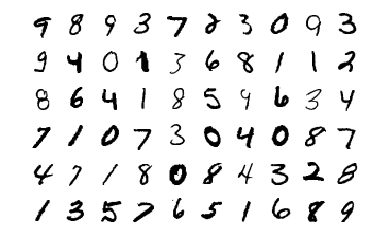

In [31]:
import matplotlib.pyplot as plt
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Design the model

In [32]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
      
      

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

model = CNN().to(device)

print(model)

print(sum(p.numel() for p in model.parameters()))


CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
53370


# Optimisation function

In [0]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
loss_function = nn.CrossEntropyLoss()

# Time for training!

In [0]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_data_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = loss_function(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_data_loader.dataset),
                100. * batch_idx / len(train_data_loader), loss.data.item()))


def validate(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_data_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += loss_function(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_data_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_data_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_data_loader.dataset), accuracy))
      

In [35]:
%%time
epochs = 5

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293232
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.134223
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.934439
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.197879
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.724063

Test set: Average loss: 0.5571, Accuracy: 8588/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.632380
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.340601
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.742629
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.305348
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.304398

Test set: Average loss: 0.2872, Accuracy: 9151/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.413737
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.319234
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.282195
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.206018
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.287842

Test set: Average loss: 0.2085, Accuracy: 9394/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.329629
Train Epoch: 4 [12800/60000 (21%)]	Lo

[9]
[8]
[6]
[9]
[6]
[2]
[7]
[5]
[8]
[8]


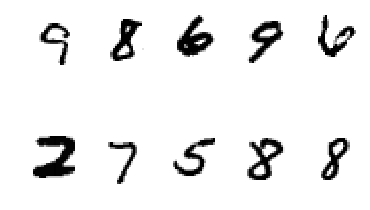

In [36]:
import numpy as np
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(2, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    img = images[index].data.numpy()
    img = np.expand_dims(img, axis=0)
    prediction = model(torch.tensor(img).to(device)).data.max(1)[1]
    print(prediction.data.cpu().numpy())

# Let's measure the accuracy of the model

Text(0.5, 1.0, 'test accuracy')

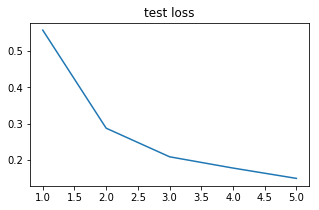

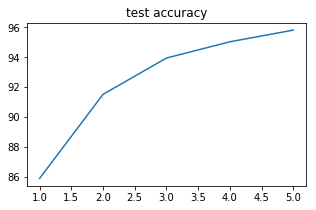

In [37]:
import numpy as np
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('test accuracy')